In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, rfft, rfftfreq, fftshift, ifftshift
from scipy import signal
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')



import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns

import scipy.signal as signal
from scipy.fft import fft

sns.set_theme(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

In [4]:
class SciPyFFTAnalyzer:
    def __init__(self, time_signal, sampling_rate):
        """
        Frequency analyzer using SciPy FFT
        
        Parameters:
        time_signal: array-like, input signal in time domain
        sampling_rate: float, sampling rate in Hz
        """
        self.signal = np.array(time_signal)
        self.fs = sampling_rate
        self.time = np.arange(len(self.signal)) / self.fs
        self.N = len(self.signal)
        
    def compute_fft(self, real_only=True):
        """
        Compute FFT using scipy.fft
        
        Parameters:
        real_only: bool, if True use rfft for real signals (more efficient)
        """
        if real_only:
            # For real signals, use rfft (more efficient)
            self.fft_vals = rfft(self.signal)
            self.freqs = rfftfreq(self.N, 1/self.fs)
            # Magnitude spectrum (normalized)
            self.magnitude = np.abs(self.fft_vals) * 2/self.N
            self.magnitude[0] /= 2  # DC component shouldn't be doubled
            if self.N % 2 == 0:
                self.magnitude[-1] /= 2  # Nyquist frequency
        else:
            # Full complex FFT
            self.fft_vals = fft(self.signal)
            self.freqs = fftfreq(self.N, 1/self.fs)
            # Get positive frequencies only
            pos_mask = self.freqs >= 0
            self.freqs = self.freqs[pos_mask]
            self.magnitude = np.abs(self.fft_vals[pos_mask]) * 2/self.N
        
        # Phase spectrum
        self.phase = np.angle(self.fft_vals)
        
        return self.freqs, self.magnitude, self.phase
    
    def compute_power_spectrum(self):
        """Compute power spectrum (magnitude squared)"""
        if not hasattr(self, 'magnitude'):
            self.compute_fft()
        
        self.power = self.magnitude ** 2
        return self.freqs, self.power
    
    def compute_psd_welch(self, nperseg=None, window='hann', overlap=0.5):
        """Compute Power Spectral Density using Welch's method"""
        if nperseg is None:
            nperseg = min(self.N//4, 256)
        
        noverlap = int(nperseg * overlap)
        
        self.psd_freqs, self.psd_vals = signal.welch(
            self.signal, 
            self.fs, 
            window=window,
            nperseg=nperseg,
            noverlap=noverlap
        )
        
        return self.psd_freqs, self.psd_vals
    
    def apply_window(self, window_type='hann'):
        """Apply window function before FFT"""
        if window_type == 'hann':
            window = signal.hann(self.N)
        elif window_type == 'hamming':
            window = signal.hamming(self.N)
        elif window_type == 'blackman':
            window = signal.blackman(self.N)
        elif window_type == 'kaiser':
            window = signal.kaiser(self.N, beta=8.6)
        else:
            window = np.ones(self.N)  # Rectangular window
        
        self.windowed_signal = self.signal * window
        return self.windowed_signal
    
    def zero_padding(self, factor=2, in_place=False):
        """
        Apply zero padding to increase frequency resolution
        
        Parameters:
        factor: int, padding factor (2 = double length, 4 = quadruple, etc.)
        in_place: bool, if True modifies the analyzer's signal, if False returns padded version
        """
        padded_length = self.N * factor
        padded_signal = np.zeros(padded_length)
        padded_signal[:self.N] = self.signal
        
        if in_place:
            # Update for FFT computation
            self.signal = padded_signal
            self.N = len(self.signal)
            # Update time array to match new signal length
            self.time = np.arange(self.N) / self.fs
        
        return padded_signal
    
    def analyze_with_padding(self, factor=2):
        """Perform FFT analysis on zero-padded signal without modifying original"""
        padded_signal = self.zero_padding(factor, in_place=False)
        
        # Create temporary analyzer for padded signal
        temp_analyzer = SciPyFFTAnalyzer(padded_signal, self.fs)
        freqs, magnitude, phase = temp_analyzer.compute_fft()
        
        return freqs, magnitude, phase
    
    def find_dominant_frequencies(self, num_peaks=5, min_height=None):
        """Find dominant frequency components"""
        if not hasattr(self, 'magnitude'):
            self.compute_fft()
        
        if min_height is None:
            min_height = np.max(self.magnitude) * 0.05
        
        # Find peaks
        peaks, properties = signal.find_peaks(
            self.magnitude, 
            height=min_height,
            distance=len(self.magnitude)//100  # Minimum distance between peaks
        )
        
        # Sort by magnitude and take top peaks
        peak_magnitudes = self.magnitude[peaks]
        sorted_indices = np.argsort(peak_magnitudes)[::-1]
        top_peaks = peaks[sorted_indices[:num_peaks]]
        
        self.dominant_freqs = self.freqs[top_peaks]
        self.dominant_magnitudes = self.magnitude[top_peaks]
        
        return self.dominant_freqs, self.dominant_magnitudes
    
    def frequency_filter(self, low_freq=None, high_freq=None):
        """Apply frequency domain filtering"""
        if not hasattr(self, 'fft_vals'):
            self.compute_fft(real_only=False)
        
        # Create filter mask
        filter_mask = np.ones(len(self.freqs), dtype=bool)
        
        if low_freq is not None:
            filter_mask &= (self.freqs >= low_freq)
        if high_freq is not None:
            filter_mask &= (self.freqs <= high_freq)
        
        # Apply filter
        filtered_fft = self.fft_vals.copy()
        filtered_fft[~filter_mask] = 0
        
        # Convert back to time domain
        self.filtered_signal = np.real(ifft(filtered_fft))
        
        return self.filtered_signal
    
    def spectral_fitting(self, fit_function='gaussian', freq_range=None):
        """Fit analytical function to spectrum"""
        if not hasattr(self, 'magnitude'):
            self.compute_fft()
        
        if freq_range is not None:
            mask = (self.freqs >= freq_range[0]) & (self.freqs <= freq_range[1])
            fit_freqs = self.freqs[mask]
            fit_magnitude = self.magnitude[mask]
        else:
            fit_freqs = self.freqs
            fit_magnitude = self.magnitude
        
        if fit_function == 'gaussian':
            def func(x, amplitude, center, sigma, offset):
                return amplitude * np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) + offset
            
            # Initial guess
            center_guess = fit_freqs[np.argmax(fit_magnitude)]
            amplitude_guess = np.max(fit_magnitude)
            sigma_guess = (fit_freqs[-1] - fit_freqs[0]) / 10
            offset_guess = np.min(fit_magnitude)
            
            initial_guess = [amplitude_guess, center_guess, sigma_guess, offset_guess]
            param_names = ['amplitude', 'center_freq', 'bandwidth', 'offset']
            
        elif fit_function == 'lorentzian':
            def func(x, amplitude, center, gamma, offset):
                return amplitude * gamma**2 / ((x - center)**2 + gamma**2) + offset
            
            center_guess = fit_freqs[np.argmax(fit_magnitude)]
            amplitude_guess = np.max(fit_magnitude)
            gamma_guess = (fit_freqs[-1] - fit_freqs[0]) / 10
            offset_guess = np.min(fit_magnitude)
            
            initial_guess = [amplitude_guess, center_guess, gamma_guess, offset_guess]
            param_names = ['amplitude', 'center_freq', 'linewidth', 'offset']
        
        try:
            popt, pcov = curve_fit(func, fit_freqs, fit_magnitude, p0=initial_guess)
            
            # Generate fitted curve
            freq_fine = np.linspace(fit_freqs[0], fit_freqs[-1], 1000)
            fitted_curve = func(freq_fine, *popt)
            
            # Calculate goodness of fit
            y_pred = func(fit_freqs, *popt)
            ss_res = np.sum((fit_magnitude - y_pred) ** 2)
            ss_tot = np.sum((fit_magnitude - np.mean(fit_magnitude)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)
            
            return {
                'fitted_params': popt,
                'param_names': param_names,
                'freq_range': freq_fine,
                'fitted_curve': fitted_curve,
                'covariance': pcov,
                'r_squared': r_squared,
                'fit_function': fit_function
            }
        except Exception as e:
            print(f"Fitting failed: {e}")
            return None
    
    def plot_comprehensive_analysis(self, show_peaks=True, fit_result=None):
        """Create comprehensive frequency analysis plots"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        # Time domain signal
        axes[0,0].plot(self.time, self.signal, 'b-', linewidth=1.5)
        axes[0,0].set_title('Time Domain Signal', fontsize=12, fontweight='bold')
        axes[0,0].set_xlabel('Time (s)')
        axes[0,0].set_ylabel('Amplitude')
        axes[0,0].grid(True, alpha=0.3)
        
        # FFT Magnitude Spectrum
        if not hasattr(self, 'magnitude'):
            self.compute_fft()
        
        axes[0,1].plot(self.freqs, self.magnitude, 'r-', linewidth=1.5)
        axes[0,1].set_title('FFT Magnitude Spectrum', fontsize=12, fontweight='bold')
        axes[0,1].set_xlabel('Frequency (Hz)')
        axes[0,1].set_ylabel('Magnitude')
        axes[0,1].grid(True, alpha=0.3)
        
        if show_peaks and hasattr(self, 'dominant_freqs'):
            axes[0,1].plot(self.dominant_freqs, self.dominant_magnitudes, 'ko', markersize=8, label='Peaks')
            axes[0,1].legend()
        
        if fit_result is not None:
            axes[0,1].plot(fit_result['freq_range'], fit_result['fitted_curve'], 'g--', linewidth=2, label=f"{fit_result['fit_function'].title()} Fit (R²={fit_result['r_squared']:.3f})")
            axes[0,1].legend()
        
        # Phase Spectrum
        if hasattr(self, 'phase'):
            axes[0,2].plot(self.freqs, np.degrees(self.phase), 'g-', linewidth=1.5)
            axes[0,2].set_title('Phase Spectrum', fontsize=12, fontweight='bold')
            axes[0,2].set_xlabel('Frequency (Hz)')
            axes[0,2].set_ylabel('Phase (degrees)')
            axes[0,2].grid(True, alpha=0.3)
        
        # Power Spectrum
        if not hasattr(self, 'power'):
            self.compute_power_spectrum()
        
        axes[1,0].semilogy(self.freqs, self.power, 'm-', linewidth=1.5)
        axes[1,0].set_title('Power Spectrum (Log Scale)', fontsize=12, fontweight='bold')
        axes[1,0].set_xlabel('Frequency (Hz)')
        axes[1,0].set_ylabel('Power')
        axes[1,0].grid(True, alpha=0.3)
        
        # PSD using Welch's method
        if not hasattr(self, 'psd_vals'):
            self.compute_psd_welch()
        
        axes[1,1].semilogy(self.psd_freqs, self.psd_vals, 'c-', linewidth=1.5)
        axes[1,1].set_title('Power Spectral Density (Welch)', fontsize=12, fontweight='bold')
        axes[1,1].set_xlabel('Frequency (Hz)')
        axes[1,1].set_ylabel('PSD (V²/Hz)')
        axes[1,1].grid(True, alpha=0.3)
        
        # Spectrogram
        nperseg = min(self.N//8, 256)
        f_spec, t_spec, Sxx = signal.spectrogram(self.signal, self.fs, nperseg=nperseg)
        
        im = axes[1,2].pcolormesh(t_spec, f_spec, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
        axes[1,2].set_title('Spectrogram', fontsize=12, fontweight='bold')
        axes[1,2].set_xlabel('Time (s)')
        axes[1,2].set_ylabel('Frequency (Hz)')
        plt.colorbar(im, ax=axes[1,2], label='Power (dB)')
        
        plt.tight_layout()
        plt.show()

-------

In [41]:
pulser_df = pd.read_pickle('pulser_dataframe.pkl')

pulser_df = pulser_df[:-3]
pulser_df

,scan,time_stamp_signal,signal,time_signal,time_stamp_waveform,waveform,time_waveform,waveform_amplitude,waveform_amplitude_var
0,12,1.716273e+09,"[4.315062048411276e-09, 3.696958565803581e-08,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[3.760714285713948e-05, 3.110714285713948e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.004638,1.512630e-11
1,1,1.716273e+09,"[2.6424179794069536e-07, -3.5533422514424417e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[7.707142857137115e-06, 1.2071428571371145e-06...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.014515,1.341216e-10
2,2,1.716273e+09,"[4.120732642532984e-08, -4.062282534129105e-08...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[-3.8164285714286054e-05, -5.7664285714286054e...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.022909,3.253645e-10
3,8,1.716272e+09,"[3.6657959838365994e-07, -5.581256948365801e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[5.771071428571395e-05, 5.121071428571395e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.032431,6.397754e-10
4,5,1.716272e+09,"[-7.574683244446494e-07, -1.0437785225215877e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[5.4460714285713954e-05, 6.746071428571396e-05...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.045656,1.416528e-09
5,13,1.716272e+09,"[-4.620886801066035e-07, 1.6080686067715828e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[1.5042857142862886e-05, 4.754285714286289e-05...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.072507,3.377835e-09
6,3,1.716272e+09,"[1.0843543790409398e-06, -1.847590937678603e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[-1.8385714285718678e-05, -3.788571428571868e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.091233,5.529557e-09
7,7,1.716272e+09,"[2.6072058841550167e-07, 6.708428623276273e-07...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[-8.171428571427897e-06, -1.6714285714278958e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.114635,8.766474e-09
8,10,1.716271e+09,"[1.3476253681308756e-06, 4.27295848431496e-07,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[4.039285714286052e-06, -1.5460714285713948e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.128655,1.036040e-08
9,9,1.716271e+09,"[1.7606980586735308e-06, 6.020718390996616e-07...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[5.065357142856738e-05, 6.365357142856738e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.161716,1.578049e-08


pulser data

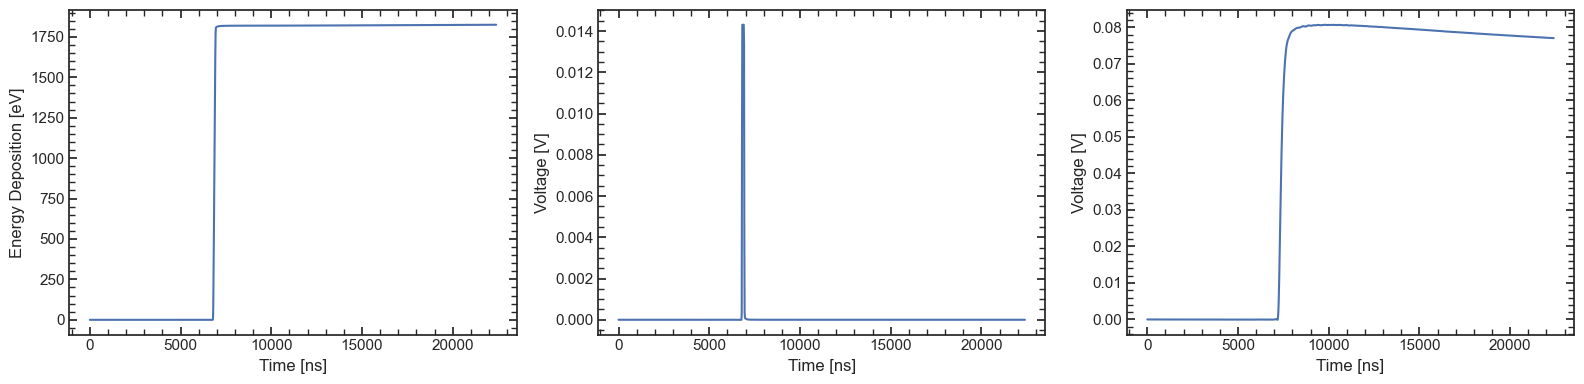

In [42]:


output_data = np.zeros((len(pulser_df['waveform']),len(pulser_df['waveform'][0])))
input_data = np.zeros((len(pulser_df['waveform']),len(pulser_df['waveform'][0])))
time_data = pulser_df['time_waveform'][0]
dt = (time_data[1] - time_data[0])*1e-9

for i, wf in enumerate(pulser_df['waveform']):
    output_data[i,:] = wf

mean_puls_wf = np.mean(output_data, axis=0)

for i, sig in enumerate(pulser_df['signal']):
    input_data[i,:] = sig

mean_puls_signal = np.mean(input_data, axis=0)


def integrate_signal(input_signal, dt):
    offset = np.mean(input_signal[:int(len(input_signal)*0.2)]) 
    output_signal = np.zeros_like(input_signal)
    effective_signal = input_signal - offset  

    for i in range(1, len(input_signal)):
        input_contribution = (effective_signal[i] + effective_signal[i-1]) * dt / 2 
        output_signal[i] = output_signal[i-1] + input_contribution
    
    return output_signal 

energy_deposition = integrate_signal(mean_puls_signal, dt)*1e12


plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
plt.plot(time_data, energy_deposition, label='Mean Input Signal')
plt.xlabel('Time [ns]')
plt.ylabel('Energy Deposition [eV]')

plt.subplot(1,3,2)
plt.plot(time_data, mean_puls_signal, label='Mean Input Signal')
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [V]')

plt.subplot(1,3,3)
plt.plot(time_data, mean_puls_wf, label='Mean Output Waveform')
plt.xlabel('Time [ns]')
plt.ylabel('Voltage [V]')

plt.tight_layout();


=== SciPy FFT Frequency Analysis ===
Frequency resolution: 44610.97 Hz
Maximum frequency: 31227678.6 Hz

Dominant frequencies:
  Peak 1: 223054.8 Hz (magnitude: 230.476)
  Peak 2: 669164.5 Hz (magnitude: 72.979)
Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

Applied Hann window to signal
Zero padding analysis: improved frequency resolution from 44610.97 Hz to 11152.74 Hz


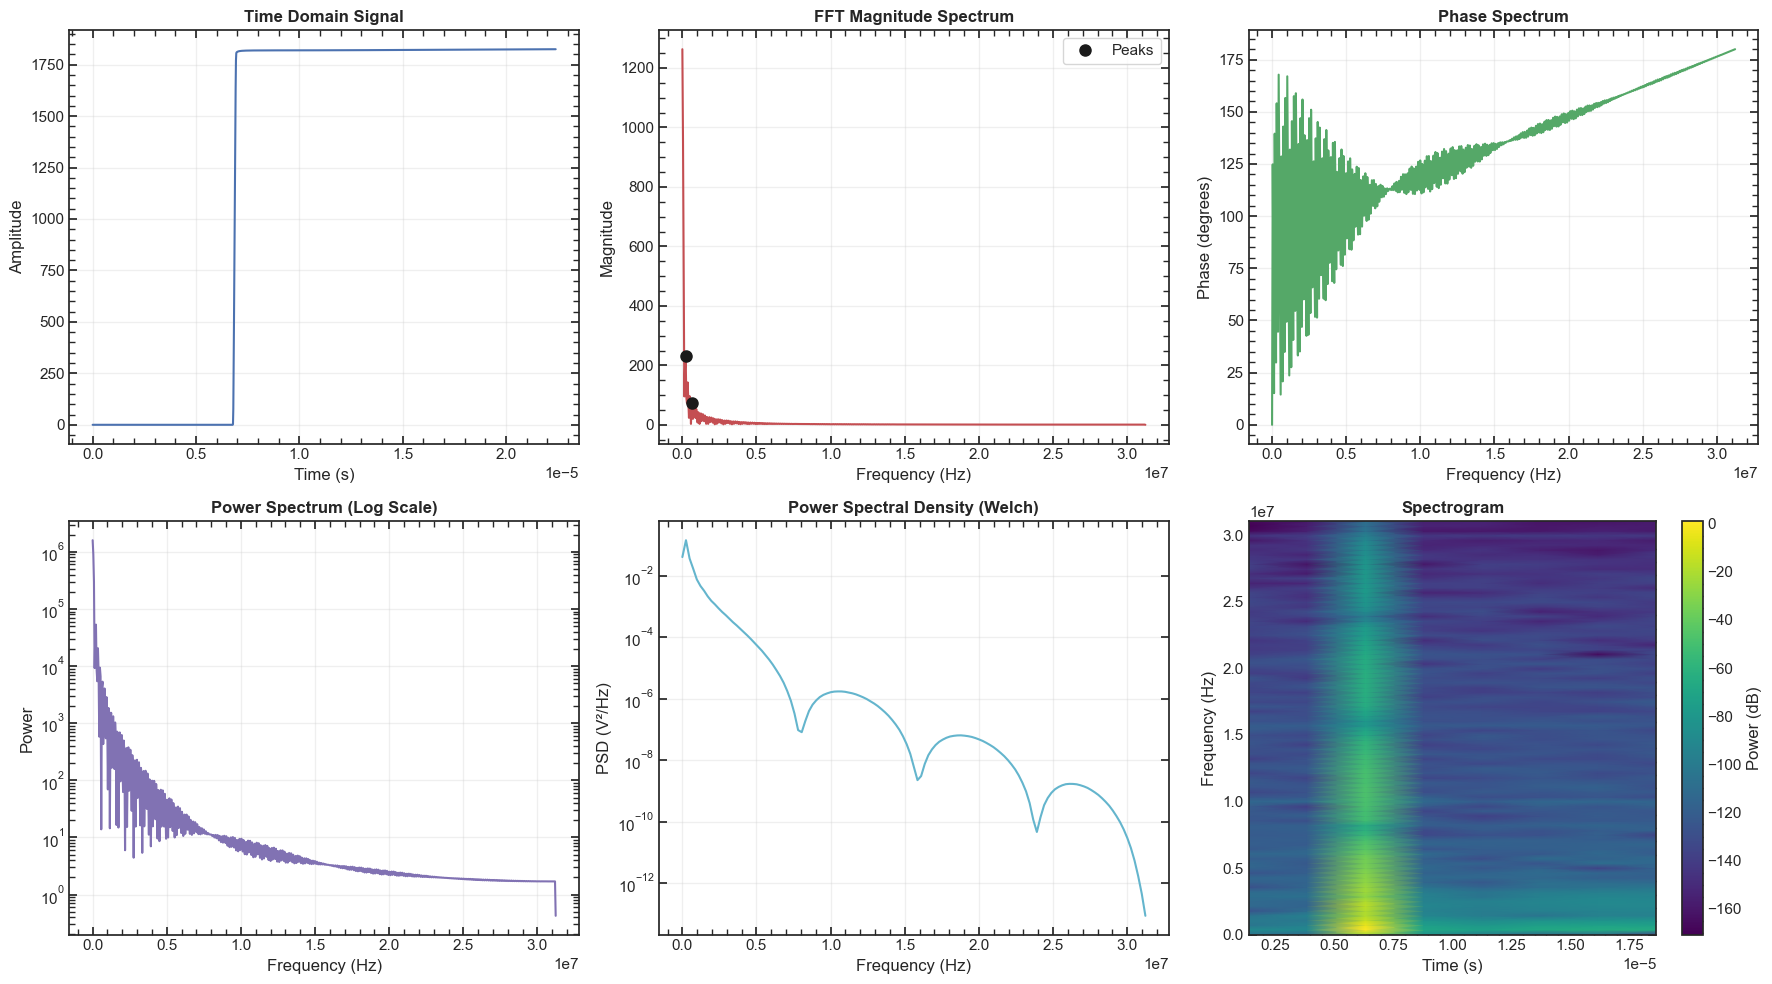

In [43]:
test_signal = energy_deposition
sampling_rate = 1 / dt


analyzer = SciPyFFTAnalyzer(test_signal, sampling_rate)

print("=== SciPy FFT Frequency Analysis ===")

# Basic FFT analysis
freqs, magnitude, phase = analyzer.compute_fft()
print(f"Frequency resolution: {freqs[1] - freqs[0]:.2f} Hz")
print(f"Maximum frequency: {freqs[-1]:.1f} Hz")

# Find dominant frequencies
dom_freqs, dom_mags = analyzer.find_dominant_frequencies(num_peaks=7)
print(f"\nDominant frequencies:")
for i, (freq, mag) in enumerate(zip(dom_freqs, dom_mags)):
    print(f"  Peak {i+1}: {freq:.1f} Hz (magnitude: {mag:.3f})")

# Spectral fitting example
fit_result = analyzer.spectral_fitting()
if fit_result:
    params = fit_result['fitted_params']
    names = fit_result['param_names']
    print(f"\nGaussian fit around 50 Hz:")
    for name, param in zip(names, params):
        print(f"  {name}: {param:.3f}")
    print(f"  R-squared: {fit_result['r_squared']:.4f}")

# Apply window function
windowed = analyzer.apply_window('hann')
print(f"\nApplied Hann window to signal")

# Zero padding (analyze without modifying original)
padded_freqs, padded_mag, _ = analyzer.analyze_with_padding(factor=4)
print(f"Zero padding analysis: improved frequency resolution from {freqs[1]-freqs[0]:.2f} Hz to {padded_freqs[1]-padded_freqs[0]:.2f} Hz")

# Create comprehensive plots (using original signal)
analyzer.plot_comprehensive_analysis(show_peaks=True, fit_result=fit_result)

=== SciPy FFT Frequency Analysis ===
Frequency resolution: 44610.97 Hz
Maximum frequency: 31227678.6 Hz

Dominant frequencies:
  Peak 1: 178443.9 Hz (magnitude: 0.011)
  Peak 2: 624553.6 Hz (magnitude: 0.003)

Gaussian fit around 50 Hz:
  amplitude: 0.053
  center_freq: 8210.671
  bandwidth: 58044.278
  offset: 0.000
  R-squared: 0.9389

Applied Hann window to signal
Zero padding analysis: improved frequency resolution from 44610.97 Hz to 11152.74 Hz


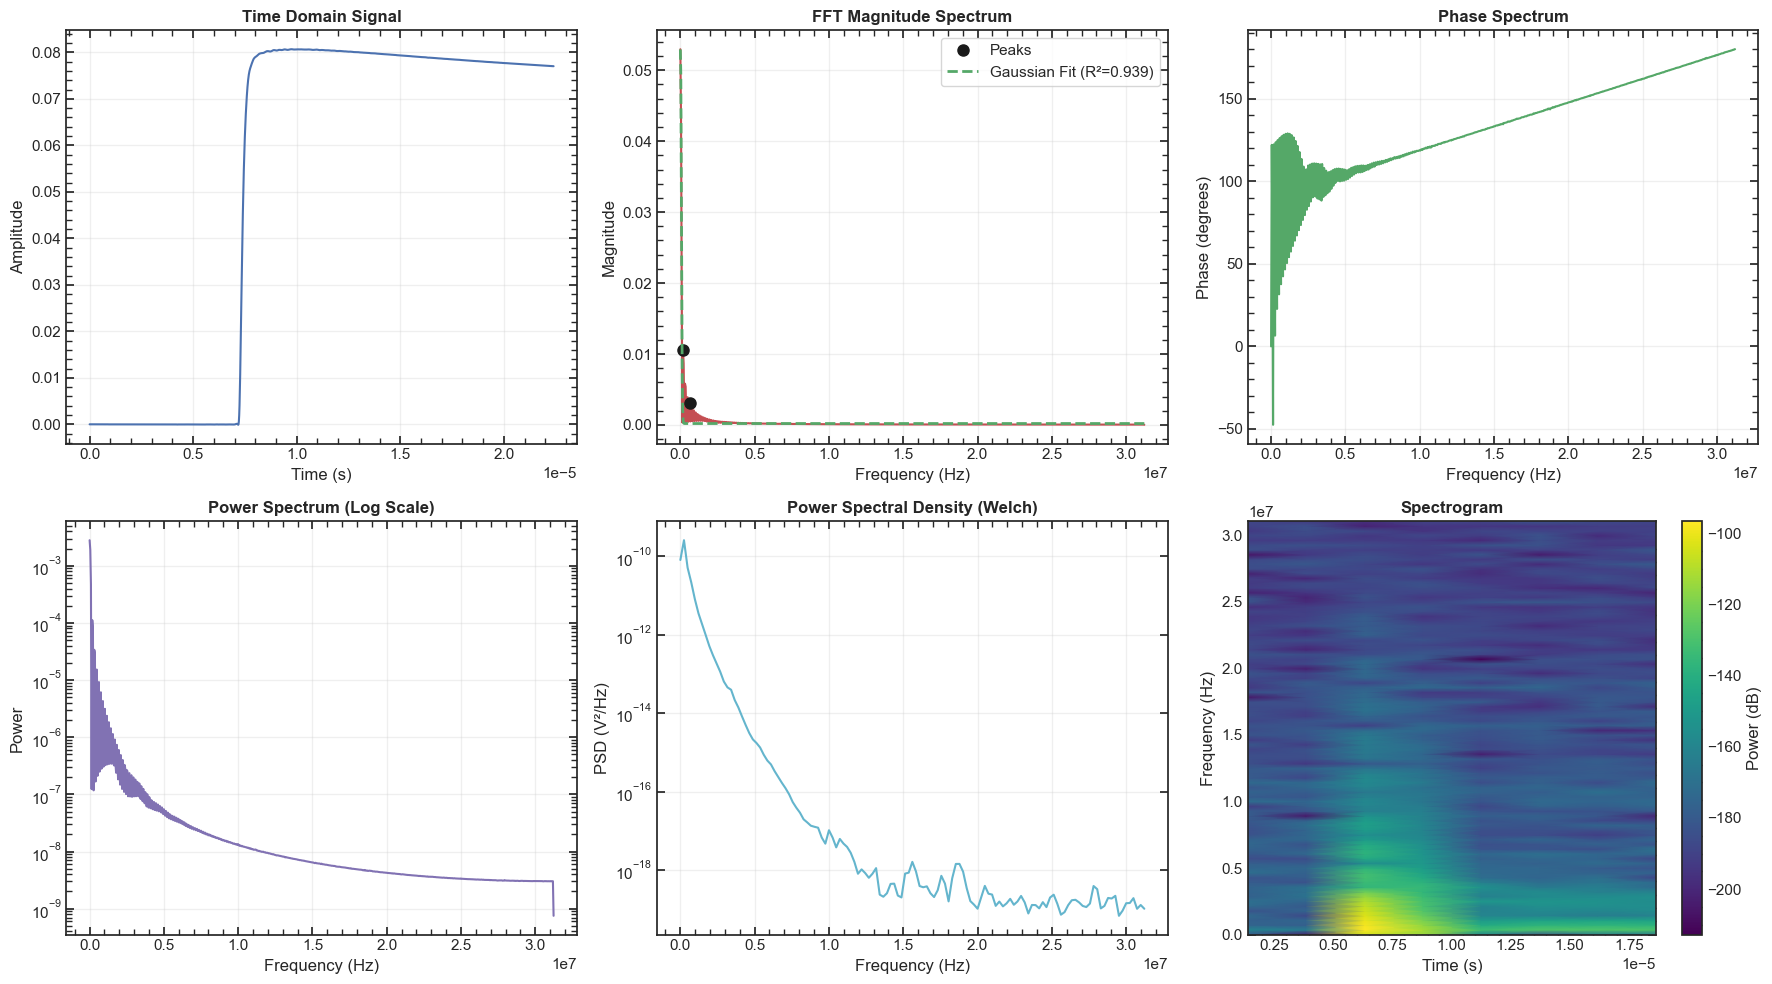

In [44]:
test_signal = mean_puls_wf
sampling_rate = 1 / dt


analyzer = SciPyFFTAnalyzer(test_signal, sampling_rate)

print("=== SciPy FFT Frequency Analysis ===")

# Basic FFT analysis
freqs, magnitude, phase = analyzer.compute_fft()
print(f"Frequency resolution: {freqs[1] - freqs[0]:.2f} Hz")
print(f"Maximum frequency: {freqs[-1]:.1f} Hz")

# Find dominant frequencies
dom_freqs, dom_mags = analyzer.find_dominant_frequencies(num_peaks=7)
print(f"\nDominant frequencies:")
for i, (freq, mag) in enumerate(zip(dom_freqs, dom_mags)):
    print(f"  Peak {i+1}: {freq:.1f} Hz (magnitude: {mag:.3f})")

# Spectral fitting example
fit_result = analyzer.spectral_fitting()
if fit_result:
    params = fit_result['fitted_params']
    names = fit_result['param_names']
    print(f"\nGaussian fit around 50 Hz:")
    for name, param in zip(names, params):
        print(f"  {name}: {param:.3f}")
    print(f"  R-squared: {fit_result['r_squared']:.4f}")

# Apply window function
windowed = analyzer.apply_window('hann')
print(f"\nApplied Hann window to signal")

# Zero padding (analyze without modifying original)
padded_freqs, padded_mag, _ = analyzer.analyze_with_padding(factor=4)
print(f"Zero padding analysis: improved frequency resolution from {freqs[1]-freqs[0]:.2f} Hz to {padded_freqs[1]-padded_freqs[0]:.2f} Hz")

# Create comprehensive plots (using original signal)
analyzer.plot_comprehensive_analysis(show_peaks=True, fit_result=fit_result)